In [2]:
import pandas as pd
import numpy as np
import tempfile
import tensorflow as tf
import pandas as pd

In [3]:
sample_train_pickle = pd.read_pickle('../data_20220831/sample_train_processed_processed.pkl')

In [74]:
sample_test_pickle = pd.read_pickle('../data_20220831/sample_test_processed_processed.pkl')

In [4]:
sample_train_pickle.shape

(58504, 25)

In [75]:
sample_test_pickle.shape

(14627, 25)

In [5]:
sample_train_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58504 entries, 0 to 58503
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cv_id                          58504 non-null  object 
 1   jd_id                          58504 non-null  object 
 2   model_label                    58504 non-null  int64  
 3   age                            58504 non-null  float64
 4   degree_index_cv                58504 non-null  int64  
 5   degree_index_jd                58504 non-null  int64  
 6   degree_match_cvjd              58504 non-null  int64  
 7   description_tfidf_pca          58504 non-null  object 
 8   equal_job                      58504 non-null  int64  
 9   gender_index_cv                58504 non-null  int64  
 10  job_intentstatus_cv            58504 non-null  int64  
 11  keyU                           58504 non-null  int64  
 12  kills_tfidf_pca                58504 non-null 

In [6]:
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f','','kernel')

flags.DEFINE_string("model_dir", "../modelV0907", "Base directory for output models.") #模型输出路径
flags.DEFINE_integer("train_steps", 100, "Number of training steps.") 


In [10]:
COLUMNS = ['age', 'recruit_number', 'workYear', 'min_annual_salary', 'max_annual_salary', 
            'degree_index_cv', 'degree_index_jd', 'gender_index_cv', 'job_intentstatus_cv',
            'description_tfidf_pca', 'position_tfidf_pca', 'requirement_tfidf_pca', 'kills_tfidf_pca', 'title_category_tags_tfidf_pca',
            'work_duration_mean', 'equal_job', 'parsed_desiredSalary', 'school_intersect_cvjd', 'location_intersect_cvjd',
            'degree_match_cvjd', 'workyear_match_cvjd', 'keyU']

LABEL_COLUMN = "model_label"

# 离散特征
CATEGORICAL_COLUMNS = ['degree_index_cv', 'degree_index_jd', 'gender_index_cv', 'job_intentstatus_cv', 'school_intersect_cvjd',
                        'location_intersect_cvjd', 'degree_match_cvjd', 'workyear_match_cvjd', 'keyU']

# 文本向量特征
ARRAY_COLUMNS = ['description_tfidf_pca', 'position_tfidf_pca', 'requirement_tfidf_pca', 'kills_tfidf_pca', 'title_category_tags_tfidf_pca']

# 连续特征
CONTINUOUS_COLUMNS = ['age', 'recruit_number', 'workYear', 'min_annual_salary', 'max_annual_salary', 
                    'work_duration_mean', 'equal_job', 'parsed_desiredSalary', ]


In [12]:
model_dir = tempfile.mkdtemp() if not '../modelV0907' else '../modelV0907'
print("model dir = %s" % model_dir)

model dir = ../modelV0907


In [13]:
def col2arr(data,col):
    slist = []
    for i in tuple(data.index):
        slist.append(np.array(data.loc[i,col]))
    return np.array(slist)

def input_fn(df):
    continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
    array_cols = {k: tf.constant(col2arr(df,k)) for k in ARRAY_COLUMNS}
    categorical_cols = {k: tf.SparseTensor(indices=[[i,0] for i in range( df[k].size)], values = df[k].values, dense_shape=[df[k].size,1]) for k in CATEGORICAL_COLUMNS}
    
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    feature_cols.update(array_cols)
    
    label = tf.constant(df[LABEL_COLUMN].values)

    return feature_cols, label

In [14]:
CATEGORICAL_COLUMNS = ['degree_index_cv', 'degree_index_jd', 'gender_index_cv', 'job_intentstatus_cv', 'school_intersect_cvjd',
                        'location_intersect_cvjd', 'degree_match_cvjd', 'workyear_match_cvjd', 'keyU']

# 文本向量特征
ARRAY_COLUMNS = ['description_tfidf_pca', 'position_tfidf_pca', 'requirement_tfidf_pca', 'kills_tfidf_pca', 'title_category_tags_tfidf_pca']

# 连续特征
CONTINUOUS_COLUMNS = ['age', 'recruit_number', 'workYear', 'min_annual_salary', 'max_annual_salary', 
                    'work_duration_mean', 'equal_job', 'parsed_desiredSalary', ]

In [ ]:
'''
tf.feature_column.categorical_column_with_identity(
    key, num_buckets, default_value=None
)
Use this when your inputs are integers in the range [0, num_buckets), 
and you want to use the input value itself as the categorical ID. 
Values outside this range will result in default_value if specified, otherwise it will fail.
'''

In [50]:
# cv的特征一开始是3-10，后来减去了3，变成0-7
# jd的学历特征也减去了3
sample_train_pickle['workyear_match_cvjd'].value_counts()

0    32766
1    25738
Name: workyear_match_cvjd, dtype: int64

In [35]:
sample_train_pickle['title_category_tags_tfidf_pca'][0].__len__()

30

In [55]:
# 将类别特征变成onehot，default_value需要注意
degree_index_cv = tf.feature_column.categorical_column_with_identity('degree_index_cv', num_buckets=8, default_value=0)
degree_index_jd = tf.feature_column.categorical_column_with_identity('degree_index_jd', num_buckets=8, default_value=0)
gender_index_cv = tf.feature_column.categorical_column_with_identity('gender_index_cv', num_buckets=3, default_value=0)
job_intentstatus_cv = tf.feature_column.categorical_column_with_identity('job_intentstatus_cv', num_buckets=4, default_value=0)
school_intersect_cvjd = tf.feature_column.categorical_column_with_identity('school_intersect_cvjd', num_buckets=2, default_value=0)
location_intersect_cvjd = tf.feature_column.categorical_column_with_identity('location_intersect_cvjd', num_buckets=2, default_value=0)
degree_match_cvjd = tf.feature_column.categorical_column_with_identity('degree_match_cvjd', num_buckets=2, default_value=0)
workyear_match_cvjd = tf.feature_column.categorical_column_with_identity('workyear_match_cvjd', num_buckets=2, default_value=0)
keyU = tf.feature_column.categorical_column_with_identity('keyU', num_buckets=2, default_value=0)

# 多维数值特征输入
description_tfidf_pca = tf.feature_column.numeric_column(key="description_tfidf_pca",shape=70)
position_tfidf_pca = tf.feature_column.numeric_column(key="position_tfidf_pca",shape=40)
requirement_tfidf_pca = tf.feature_column.numeric_column(key="requirement_tfidf_pca",shape=70)
kills_tfidf_pca = tf.feature_column.numeric_column(key="kills_tfidf_pca",shape=30)
title_category_tags_tfidf_pca = tf.feature_column.numeric_column(key="title_category_tags_tfidf_pca",shape=30)

# 一维数值特征，还没归一化
age = tf.feature_column.numeric_column("age", default_value=0.0)
recruit_number = tf.feature_column.numeric_column("recruit_number", default_value=0.0)
workYear = tf.feature_column.numeric_column("workYear", default_value=0.0)
min_annual_salary = tf.feature_column.numeric_column("min_annual_salary", default_value=0.0)
max_annual_salary = tf.feature_column.numeric_column("max_annual_salary", default_value=0.0)
work_duration_mean = tf.feature_column.numeric_column("work_duration_mean", default_value=0.0)
equal_job = tf.feature_column.numeric_column("equal_job", default_value=0.0)
parsed_desiredSalary = tf.feature_column.numeric_column("parsed_desiredSalary", default_value=0.0)

# 连续特征分桶onehot
# 连续特征离散化后只会出现在wide侧。
# 思考下：1.哪些特征可以放入wide侧 2.桶的范围
age_buckets = tf.feature_column.bucketized_column(age, boundaries= [18, 25, 30, 35, 40, 45])
recruit_number_buckets = tf.feature_column.bucketized_column(recruit_number, boundaries= [5, 10, 15])
workYear_buckets = tf.feature_column.bucketized_column(workYear, boundaries= [3, 5, 10, 15, 20])
work_duration_mean_buckets = tf.feature_column.bucketized_column(work_duration_mean, boundaries= [365, 547, 730, 1095, 1460])
equal_job_buckets = tf.feature_column.bucketized_column(equal_job, boundaries= [3, 5, 7, 10])
# 还有3个salary特征没有处理


In [59]:
# 类别特征onehot
# 连续数值特征分桶离散化
# 交叉特征
wide_columns = [
                degree_index_cv, degree_index_jd, gender_index_cv, job_intentstatus_cv, 
                school_intersect_cvjd, location_intersect_cvjd, degree_match_cvjd, workyear_match_cvjd, keyU,
                age_buckets, recruit_number_buckets, workYear_buckets, work_duration_mean_buckets, equal_job_buckets,
                tf.feature_column.crossed_column([degree_index_cv, degree_index_jd], hash_bucket_size=int(1e2)),
                tf.feature_column.crossed_column([degree_index_cv, workYear_buckets], hash_bucket_size=int(1e2)),
                tf.feature_column.crossed_column([degree_index_cv, gender_index_cv, age_buckets], hash_bucket_size=int(1e2)),
                tf.feature_column.crossed_column([school_intersect_cvjd, degree_match_cvjd, workyear_match_cvjd, keyU], hash_bucket_size=int(1e2)),
                ]

# 文本向量特征
# 类别特征onehot之后接入embedding层
# 连续的数值特征没有接入
deep_columns = [
                description_tfidf_pca, position_tfidf_pca, requirement_tfidf_pca, kills_tfidf_pca, title_category_tags_tfidf_pca,
                tf.feature_column.embedding_column(degree_index_cv, 8),
                tf.feature_column.embedding_column(degree_index_jd, 8),
                tf.feature_column.embedding_column(gender_index_cv, 8),
                tf.feature_column.embedding_column(school_intersect_cvjd, 8),
                tf.feature_column.embedding_column(location_intersect_cvjd, 8),
                tf.feature_column.embedding_column(degree_match_cvjd, 8),
                tf.feature_column.embedding_column(workyear_match_cvjd, 8),
                tf.feature_column.embedding_column(keyU, 8),
                ]

In [47]:
# 黄金数据集的分位点
percent_list = list(range(1, 10)) 
percent_list.extend([9.5, 9.6, 9.7, 9.8, 9.9, 10])
percent_list = map(lambda x: x*10, percent_list)

# 计算分位点
for percent in percent_list:
    num = np.percentile(sample_train_pickle['work_duration_mean'], percent, interpolation='midpoint')
    print("%{}的分位点是：{}".format(percent, num))

%10的分位点是：425.33333333333326
%20的分位点是：547.0
%30的分位点是：633.2
%40的分位点是：720.3333333333335
%50的分位点是：783.5
%60的分位点是：852.0
%70的分位点是：966.75
%80的分位点是：1116.0
%90的分位点是：1393.9
%95.0的分位点是：1674.5833333333335
%96.0的分位点是：1766.75
%97.0的分位点是：1886.5
%98.0的分位点是：2084.25
%99.0的分位点是：2466.0
%100的分位点是：3624.0


In [65]:
est_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 50,    # Save checkpoints every this many steps. 
    keep_checkpoint_max = 0,       # If None or 0, all checkpoint files are kept. 
)


m = tf.estimator.DNNLinearCombinedClassifier(model_dir=model_dir, 
                                            linear_feature_columns=wide_columns, 
                                            dnn_feature_columns = deep_columns, 
                                            dnn_hidden_units=[200, 100, 30, 10],
                                            config=est_config)

INFO:tensorflow:Using config: {'_model_dir': '../modelV0907', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 50, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 0, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7ee42e6128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [66]:
m.train(input_fn=lambda: input_fn(sample_train_pickle), steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../modelV0907/model.ckpt.
INFO:tensorflow:../modelV0907/model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:loss = 40720.39, step = 1
INFO:tensorflow:Saving checkpoints for 50 into ../modelV0907/model.ckpt.
INFO:tensorflow:../modelV0907/model.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Saving checkpoints for 100 into ../modelV0907/model.ckpt.
INFO:tensorflow:../modelV0907/model.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:global_step/sec: 2.49662
INFO:tensorflow:loss = 34003.176, step = 101 (40.055 sec)
INFO:tensorflow:Saving checkpoints for 150 into ../modelV0907/model.ckpt.
INFO:tensorflow:../mode

In [82]:
results = m.evaluate(input_fn=lambda: input_fn(sample_test_pickle), steps=1, checkpoint_path = '../modelV0907/model.ckpt-100')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-07T17:05:32Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2022-09-07-17:05:36
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.68763244, accuracy_baseline = 0.570657, auc = 0.74869776, auc_precision_recall = 0.693613, average_loss = 0.5868112, global_step = 100, label/mean = 0.429343, loss = 8583.287, precision = 0.69863015, prediction/mean = 0.40653765, recall = 0.47914013
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: ../modelV0907/model.ckpt-100


In [79]:
results = m.evaluate(input_fn=lambda: input_fn(sample_test_pickle), steps=1, checkpoint_path = '../modelV0907/model.ckpt-500')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-07T16:58:57Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2022-09-07-16:59:01
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.7284474, accuracy_baseline = 0.570657, auc = 0.79575986, auc_precision_recall = 0.7471512, average_loss = 0.5395019, global_step = 500, label/mean = 0.429343, loss = 7891.2944, precision = 0.7212423, prediction/mean = 0.4145149, recall = 0.59904456
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: ../modelV0907/model.ckpt-500


In [80]:
results = m.evaluate(input_fn=lambda: input_fn(sample_test_pickle), steps=1, checkpoint_path = '../modelV0907/model.ckpt-1000')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-07T16:59:29Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2022-09-07-16:59:33
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7446503, accuracy_baseline = 0.570657, auc = 0.8170671, auc_precision_recall = 0.773738, average_loss = 0.5155848, global_step = 1000, label/mean = 0.429343, loss = 7541.4595, precision = 0.73174286, prediction/mean = 0.41370174, recall = 0.6398089
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: ../modelV0907/model.ckpt-1000


In [81]:
results

{'accuracy': 0.7446503,
 'accuracy_baseline': 0.570657,
 'auc': 0.8170671,
 'auc_precision_recall': 0.773738,
 'average_loss': 0.5155848,
 'label/mean': 0.429343,
 'loss': 7541.4595,
 'precision': 0.73174286,
 'prediction/mean': 0.41370174,
 'recall': 0.6398089,
 'global_step': 1000}

In [83]:
p = m.predict(input_fn=lambda: input_fn(sample_test_pickle))

In [84]:
count = 0
pred = []
for i in p:
    if count == len(sample_test_pickle):
        break
    # i是一个字典
    pred.append(i['probabilities'])
    count += 1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [98]:
pred_label = pd.DataFrame(pred)
pred_label

,0,1
0,0.877076,0.122924
1,0.982511,0.017489
2,0.200850,0.799150
3,0.928102,0.071898
4,0.910424,0.089576
...,...,...
14622,0.182305,0.817695
14623,0.238755,0.761245
14624,0.303029,0.696971
14625,0.060288,0.939712


In [99]:
real_label = sample_test_pickle[['model_label']]
real_label

,model_label
0,0
1,0
2,0
3,0
4,0
...,...
14622,1
14623,1
14624,1
14625,1


0.8171


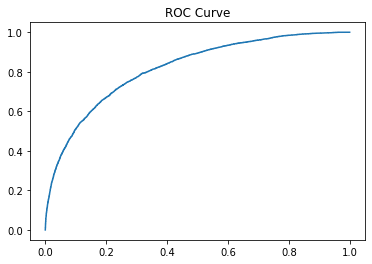

In [101]:
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plot
from sklearn.metrics import auc

y = np.array(real_label['model_label'])
scores = np.array(pred_label[1])

fpr, tpr, thresholds = metrics.roc_curve(y, scores)
AUC = round(auc(fpr, tpr), 4)
print(AUC)
plot.figure("ROC Curve")
plot.title("ROC Curve")
plot.xlabel = ('FPR')
plot.ylabel = ('TPR')
plot.plot(fpr, tpr, label='ROC')
plot.show()
